In [330]:
# Google drive data links
quantity_id = "1KBqJe3AzOlGoina3aWiNaUGT5f02EILZ"
url_quantity = f"https://drive.google.com/uc?id={quantity_id}"

In [331]:
import pandas as pd

In [332]:
# Dataframes

# Amount of fat calculated as percentage of total intake amount
quantity = pd.read_csv(url_quantity)

In [333]:
from sklearn.impute import KNNImputer

In [335]:
# KNNImputer imputes missing values using the feature values of the k-nearest neighbors

#impute missing data
def impute_missing(df):
    #transform data from object variable to numerical variable
    df['Undernourished'] = df['Undernourished'].map(lambda x: '2.4' if x == '<2.5' else x).astype('float64')

    col = list(df.columns)
    col.remove('Unit (all except Population)') #remove '%' unit
    col.remove('Country') #object variable
   
    imputer = KNNImputer(n_neighbors=3)
    imp_data = imputer.fit_transform(df[col])
    new = pd.DataFrame(imp_data, columns = col)

    return pd.concat([df[['Country']], new], axis=1) #concat 'Country' to data frame then return

In [336]:
# Impute missing data
quantity = impute_missing(quantity)

In [337]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\gympr\AppData\Local\Temp\ipykernel_20912\556559271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='Confirmed', ascending=False, inplace=True)


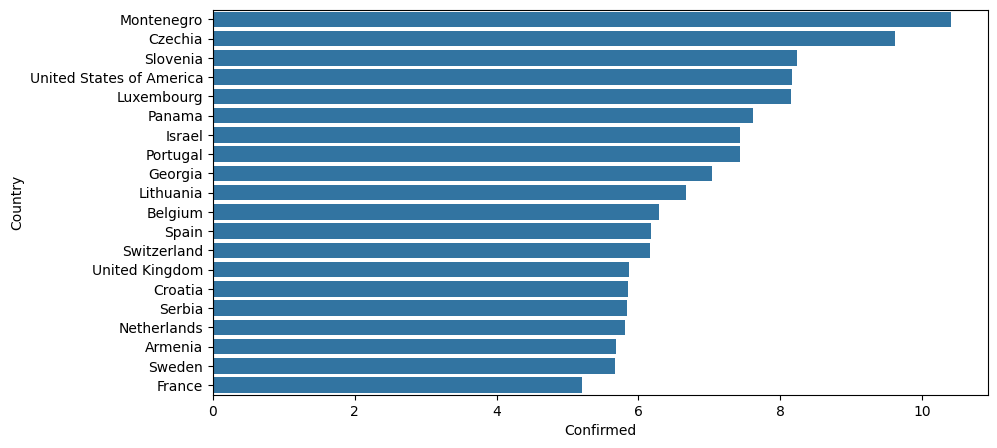

In [338]:
# Chart of number of confirmed cases by country. Based on fat data.
fig, ax = plt.subplots(figsize=(10, 5))

df = quantity[['Country', 'Confirmed', 'Deaths', 'Recovered', 'Active']]
df.sort_values(by='Confirmed', ascending=False, inplace=True)
sns.barplot(x="Confirmed", y="Country", data=df[:20]);

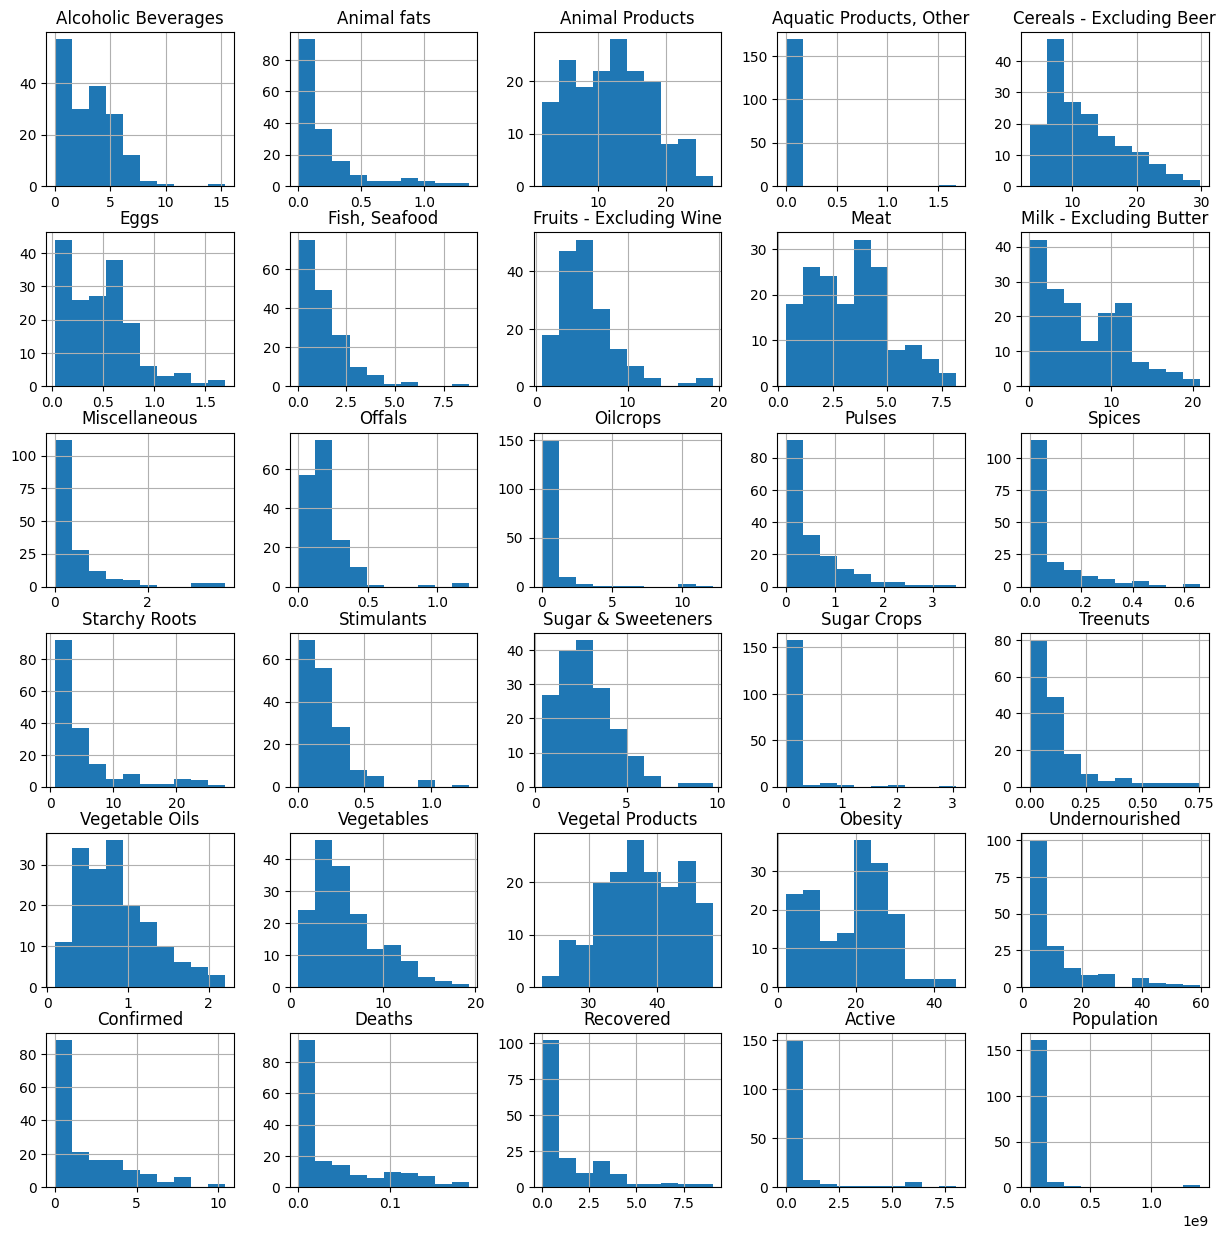

In [339]:
# Distribution of fat features
quantity = quantity.drop("Country", axis=1)
quantity.hist(figsize=(15, 15));

# Remove outliers

In [340]:
import numpy as np

In [344]:
zero_counts = (quantity == 0).sum()
zero_counts

Alcoholic Beverages           3
Animal fats                   0
Animal Products               0
Aquatic Products, Other      97
Cereals - Excluding Beer      0
Eggs                          0
Fish, Seafood                 0
Fruits - Excluding Wine       0
Meat                          0
Milk - Excluding Butter       0
Miscellaneous                13
Offals                        1
Oilcrops                      0
Pulses                        1
Spices                        3
Starchy Roots                 0
Stimulants                    0
Sugar & Sweeteners            0
Sugar Crops                 141
Treenuts                      9
Vegetable Oils                0
Vegetables                    0
Vegetal Products              0
Obesity                       0
Undernourished                0
Confirmed                     0
Deaths                        8
Recovered                     4
Active                        3
Population                    0
dtype: int64

### Remove columns with many zeros and non food columns

In [345]:
quantity = quantity.loc[:, ~quantity.columns.isin(["Undernourished", "Obesity", "Active", "Country", "Deaths", 
                                                   "Recovered", "Population", "Aquatic Products, Other", 
                                                    "Sugar Crops", "Miscellaneous"])]

# Correlation

In [455]:
# Linear corellation among data
corr_matrix = quantity.corr()
corr_matrix.sort_values(["Confirmed"],ascending = False, inplace = True)
print(corr_matrix.Confirmed)

Confirmed                   1.000000
Animal Products             0.591060
Milk - Excluding Butter     0.587517
Animal fats                 0.492008
Alcoholic Beverages         0.362946
Eggs                        0.348327
Meat                        0.277356
Stimulants                  0.263387
Sugar & Sweeteners          0.250339
Treenuts                    0.163420
Vegetables                  0.116401
Vegetable Oils             -0.046885
Fruits - Excluding Wine    -0.064146
Offals                     -0.146568
Fish, Seafood              -0.157949
Spices                     -0.160389
Oilcrops                   -0.244560
Starchy Roots              -0.298031
Pulses                     -0.334911
Cereals - Excluding Beer   -0.436735
Vegetal Products           -0.591090
Name: Confirmed, dtype: float64


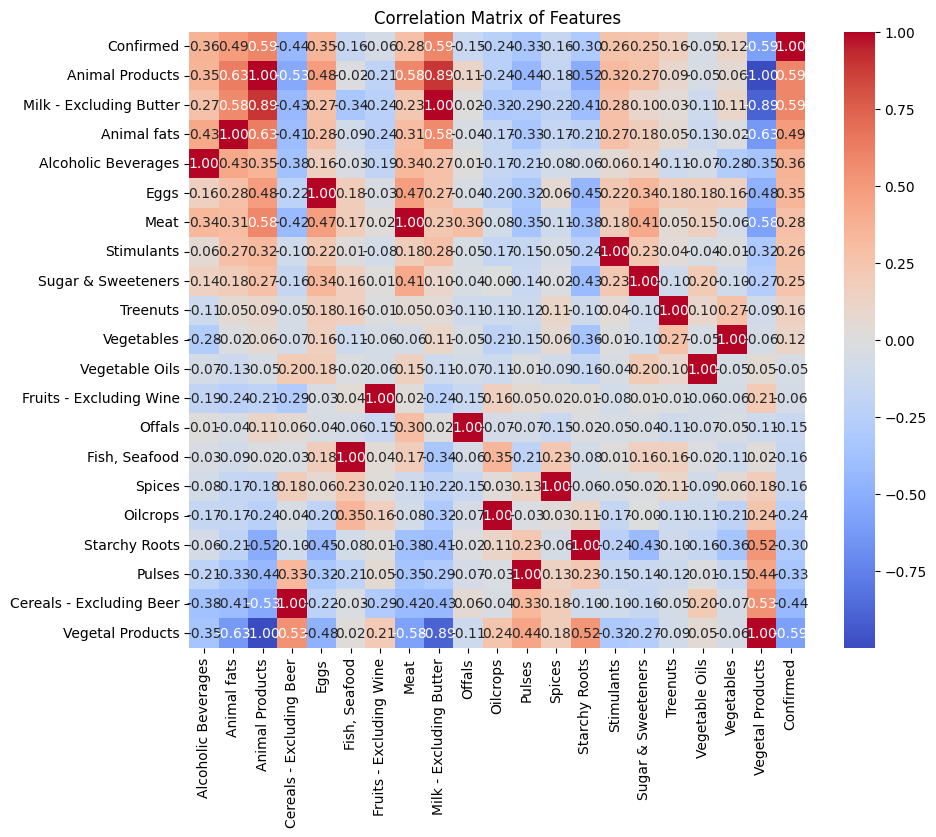

In [457]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Features')
plt.show()

# Split Data

In [350]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [352]:
X = quantity.loc[:, ~quantity.columns.isin(["Confirmed"])]
y = quantity["Confirmed"]

In [353]:
row_sum = X.iloc[0].sum()

In [354]:
row_sum

99.9272

In [355]:
# Random state 21 works well for Linear Regression
# Random state 23 works well for GBM
X_values = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_values, y, test_size=0.1, random_state=23)

# Linear Regression

In [356]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [357]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)
r2 = r2_score(y_test, y_pred)
print(r2)

2.3802367655038936
0.2954822180256653


# Gradient Boosting Regressor

In [358]:
from sklearn.ensemble import GradientBoostingRegressor

In [451]:
# Instantiate the GBM model
gbm = GradientBoostingRegressor(n_estimators=500, learning_rate=0.04, max_depth=3, random_state=34)

In [452]:
# Fit the model to the training data
gbm.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.04, n_estimators=500, random_state=34)

In [453]:
y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
print(gbm.score(X_test, y_test))

8.19240936600931
0.5464033552468812


# XGboost

In [362]:
import xgboost as xgb

In [363]:
# instantiate the classifier
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.10, max_depth=3)

# fit the classifier to the training data
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.15168404892886544

# KFold with a GridSearchCV

In [364]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR


In [377]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [378]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

In [379]:
# Instantiate the SVR regressor
svr = SVR()

In [380]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
# Evaluate the best estimator
# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best Estimator: SVR(C=10, gamma=0.001)


In [390]:
# Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
final_model = SVR(kernel='rbf', C=10, gamma=0.001)

In [382]:
import pickle
from sklearn.metrics import explained_variance_score

In [454]:
# Create KFold object
kfold = KFold(n_splits=50, shuffle=True, random_state=42)
best_accuracy = 0
# Iterate through the splits
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Initialize and train the model
    final_model.fit(X_train, y_train)
    # Evaluate the model
    accuracy = final_model.score(X_test, y_test)
    explained_variance = explained_variance_score(y_test, final_model.predict(X_test))
    print(f"R_squared: {accuracy}")
    print(f"Explained variance: {explained_variance}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        with open('model.pkl', 'wb') as file:
            pickle.dump(final_model, file)
            print(f"Model Saved with best accuracy: {best_accuracy}")

R_squared: 0.4588693334039131
Explained variance: 0.4601304632363138
Model Saved with best accuracy: 0.4588693334039131
R_squared: 0.30943810674975625
Explained variance: 0.31596459372164554
R_squared: -1.2461607065680593
Explained variance: 0.07556822445789124
R_squared: 0.6464103890389972
Explained variance: 0.64726507826035
Model Saved with best accuracy: 0.6464103890389972
R_squared: 0.6200850122777501
Explained variance: 0.6207458767547807
R_squared: 0.5692754246030108
Explained variance: 0.5770227950238491
R_squared: 0.3073210270184379
Explained variance: 0.5330048526823428
R_squared: -0.45690177580409075
Explained variance: -0.41004108754809176
R_squared: 0.5819473985612231
Explained variance: 0.634399897366789
R_squared: -139.63975317628385
Explained variance: -70.36632780091097
R_squared: -0.4899735170123247
Explained variance: 0.0845422559347484
R_squared: 0.6577834349475856
Explained variance: 0.6610254531378663
Model Saved with best accuracy: 0.6577834349475856
R_squared: 0

## Max percentage values of each column

In [394]:
feature_with_max = {}
for column in X_train.columns:
    feature_with_max[column] = round(X_train[column].max(), 0)
print(feature_with_max)



{'Alcoholic Beverages': 15.0, 'Animal fats': 1.0, 'Animal Products': 27.0, 'Cereals - Excluding Beer': 30.0, 'Eggs': 2.0, 'Fish, Seafood': 9.0, 'Fruits - Excluding Wine': 19.0, 'Meat': 8.0, 'Milk - Excluding Butter': 21.0, 'Offals': 1.0, 'Oilcrops': 12.0, 'Pulses': 3.0, 'Spices': 1.0, 'Starchy Roots': 28.0, 'Stimulants': 1.0, 'Sugar & Sweeteners': 10.0, 'Treenuts': 1.0, 'Vegetable Oils': 2.0, 'Vegetables': 19.0, 'Vegetal Products': 48.0}


In [395]:
column_range = {}
for column in X_train.columns:
    column_range[column] = X_test[column].max()
print(column_range)

{'Alcoholic Beverages': 5.373, 'Animal fats': 0.8559, 'Animal Products': 22.8328, 'Cereals - Excluding Beer': 19.9604, 'Eggs': 0.6487, 'Fish, Seafood': 1.1325, 'Fruits - Excluding Wine': 5.7297, 'Meat': 3.3604, 'Milk - Excluding Butter': 17.9487, 'Offals': 0.2185, 'Oilcrops': 0.1848, 'Pulses': 0.3708, 'Spices': 0.0486, 'Starchy Roots': 14.4675, 'Stimulants': 0.2605, 'Sugar & Sweeteners': 6.0418, 'Treenuts': 0.1309, 'Vegetable Oils': 0.564, 'Vegetables': 6.8161, 'Vegetal Products': 45.0869}
